<a href="https://colab.research.google.com/github/ColorfulWave/prediction_S-P500/blob/dev01/iTransformer_S%26P500_%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install uv
!uv pip install tensorflow
!uv pip install fredapi
!uv pip install yfinance
!uv pip install python-dotenv

Using Python 3.11.13 environment at: /usr
Audited 1 package in 75ms
Using Python 3.11.13 environment at: /usr
Audited 1 package in 70ms
Using Python 3.11.13 environment at: /usr
Audited 1 package in 71ms
Using Python 3.11.13 environment at: /usr
Resolved 1 package in 27ms
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
Prepared 1 package in 5ms
Installed 1 package in 2ms
 + python-dotenv==1.1.1


In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
# --- 設定とAPIキー ---
from dotenv import load_dotenv

# .env ファイルから環境変数をロード
load_dotenv()

# --- 設定とAPIキー ---
# FRED APIキーを環境変数から取得
fred_api_key = os.getenv('FRED_API_KEY')
if fred_api_key is None:
    raise ValueError("FRED_API_KEY が .env ファイルに設定されていません。")

fred = Fred(api_key=fred_api_key) # APIキーを初期化


# データの開始日と終了日
START_DATE = '2000-01-01'
END_DATE = datetime.date.today().strftime('%Y-%m-%d') # 現在の日付まで

# 情報の取得と補完

In [4]:
fred_series_for_model = {
    # 主要マクロ経済指標 (既存)
    'Industrial Production': 'INDPRO',
    'Unemployment Rate': 'UNRATE',
    'CPI (All Urban)': 'CPIAUCSL',
    'Federal Funds Rate': 'FEDFUNDS',
    '10-Year Treasury Yield': 'DGS10',
    '2-Year Treasury Yield': 'DGS2',
    'VIX Index': 'VIXCLS',
    'Oil Price WTI': 'DCOILWTICO',
    'Consumer Sentiment': 'UMCSENT',
    'M2 Money Stock': 'M2SL',
    'Initial Claims': 'ICSA',
    'Personal Consumption Expenditures': 'PCEC',
    'Producer Price Index': 'PPIACO',
    'Housing Starts': 'HOUST',

    # 金融政策・金利指標 (既存)
    '10-Year Breakeven Inflation Rate': 'T10YIE',
    'Effective Federal Funds Rate': 'EFFR',
    'Bank Prime Loan Rate': 'PRIME',
    'TED Spread': 'TEDRATE',

    # インフレ関連 (既存)
    'PCE Price Index': 'PCEPI',
    'PCE Price Index Excl. Food and Energy': 'PCEPILFE',

    # 労働市場関連 (既存)
    'All Employees, Total Nonfarm Payrolls': 'PAYEMS',
    'Average Hourly Earnings': 'AHETPI',

    # 住宅・不動産市場 (既存)
    'New Home Sales': 'HSN1F',
    'Existing Home Sales': 'EXHOSLUSM495S',
    'S&P/Case-Shiller U.S. National HPI': 'CSUSHPINSA',

    # 製造業・産業指標（既存 & 重複除去）
    # 'Durable Goods Orders': 'DGORDER', # 後で再度追加されるため重複
    'Capacity Utilization': 'TCU',
    'Manufacturing Capacity Utilization': 'CUMFNS',
    'Industrial Production: Manufacturing': 'IPMAN',
    # 'New Orders: Durable Goods': 'DGORDER', # 後で再度追加されるため重複
    'New Orders: Nondefense Capital Goods ex Aircraft': 'NEWORDER',
    'Business Inventories': 'BUSINV',
    'Inventory to Sales Ratio': 'ISRATIO',
    'Chicago Fed National Activity Index': 'CFNAI',

    # 為替・国際指標 (既存)
    'Euro to U.S. Dollar Exchange Rate': 'DEXUSEU',
    'Japanese Yen to U.S. Dollar Exchange Rate': 'DEXJPUS',
    'Trade Weighted US Dollar Index: Broad': 'DTWEXBGS',

    # コモディティ価格 (既存)
    'Gold Price: London Fixing': 'IR14270',
    'Copper Price': 'PCOPPUSDM',
    'Brent Crude Oil Price': 'DCOILBRENTEU',

    # GDP・所得・消費 (既存)
    'Real Gross Domestic Product': 'GDPC1',
    'Retail Sales': 'RSALES',
    'Personal Income': 'PI',
    'Retail Sales Excl Auto': 'RSXFS',

    # 人口統計 (既存)
    'Total US Population': 'POP',
    'Civilian Noninstitutional Population': 'CNP16OV',
    # 'Resident Population 16+': 'CNP16OV', # 上と重複

    # 移民関連統計 (既存)
    'Foreign-Born Labor Force': 'LNS11000006',
    'Foreign Born Employment Level': 'LNS12032194',
    'Foreign Born Population': 'LNU00073395',

    # FRB政策金利上限 (既存)
    'FRB Target Rate Upper Bound': 'DFEDTARU',

    # --- ここから追加提案分 ---

    # 市場センチメント/リスク指標
    'AAII Investor Sentiment Survey (Bullish %)': 'AAII_BULL', # 週次
    # 'Personal Saving Rate': 'PSAVERT', # 既存で含まれている

    # 金融環境/信用状況
    # 'Commercial and Industrial Loans': 'BUSLOANS', # 既存で含まれている
    # 'Total Consumer Credit Outstanding': 'TOTALSL', # 既存で含まれている
    'Monetary Base': 'BOGMBASE', # 週次
    'St. Louis Fed Financial Stress Index': 'STLFSI', # 週次
    'BAA Corporate Bond Yield minus 10-Year Treasury Yield': 'BAA10Y', # 日次

    # 不動産市場の深掘り
    # 'Housing Starts': 'HOUST', # 既存で含まれている
    'Building Permits, Total': 'PERMIT', # 月次
    '30-Year Fixed Rate Mortgage Average in the United States': 'MORTGAGE30US', # 週次

    # 国際経済/貿易
    'Real GDP for China': 'CPGDPAI', # 四半期
    'Real GDP for Euro Area': 'EUGDPRQFN', # 四半期
    'Exports of Goods and Services': 'BOPGSTB', # 月次
    'Imports of Goods and Services': 'BOPIMPGSA', # 月次

    # コモディティ価格の多様化
    'Natural Gas Price (Henry Hub)': 'DHHNGSP', # 日次
    'Silver Price: London Fixing': 'PMFIXAM', # 日次

    # 労働市場の質/ダイナミクス
    # 'Job Openings: Total Nonfarm': 'JTSJOL', # 既存で含まれている
    # 'Labor Force Participation Rate': 'CIVPART', # 既存で含まれている
    'Quits Level: Total Nonfarm': 'JTSQUL', # 月次

    # 景気先行指標の多様化
    # 'Leading Index for the United States': 'USSLIND', # 既存で含まれている
    # 'NFIB Small Business Optimism Index': 'SBOITTL', # 既存で含まれている
    'Consumer Confidence Index (CCI)': 'CSCICP01USM665S', # 月次

    # その他
    # 'Retail Sales Excl Auto': 'RSXFS', # 既存で含まれている
    'Government Consumption Expenditures & Gross Investment': 'GCE', # 四半期

    # 製造業関連の重複を整理し、新しいものを追加
    'Durable Goods Orders': 'DGORDER', # 既存で一番上にあるため、ここに集約
    'New Orders, Durable Goods excl Defense': 'ADXDNO',
    'New Orders, Consumer Durable Goods': 'UCDGNO',
    'Manufacturers Sales': 'MNFCTRSMSA',
    'Total Manufacturing New Orders (SA)': 'AMTMNO', # 新規追加
    'Total Manufacturing New Orders (NSA)': 'UMTMNO', # 新規追加
}


def get_fred_data(series_dict, start_date, end_date):
    """FREDから経済指標データを取得し、日次データに変換して結合する"""
    df_list = []
    print("FREDデータを取得中...")
    for name, series_id in series_dict.items():
        try:
            data = fred.get_series(series_id, start_date, end_date)
            if data is not None and not data.empty:
                data = data.rename(name).to_frame()
                data.index = pd.to_datetime(data.index)
                df_list.append(data)
                print(f"  - {name} ({series_id}) 取得完了。")
            else:
                print(f"  - 警告: {name} ({series_id}) のデータが取得できませんでした。")
        except Exception as e:
            print(f"  - エラー: {name} ({series_id}) の取得中にエラーが発生しました: {e}")

    if not df_list:
        raise ValueError("FREDからデータを一つも取得できませんでした。APIキーとシリーズIDを確認してください。")

    # 全てのFREDデータを結合
    fred_df = pd.concat(df_list, axis=1)
    fred_df = fred_df.asfreq('D') # 日次頻度に変換
    fred_df = fred_df.ffill() # 前の値で欠損値を埋める (経済指標は更新頻度が低いため)
    fred_df = fred_df.bfill() # 残った欠損値は次の値で埋める (最初の方の欠損対策)
    fred_df = fred_df.astype(np.float32) # メモリ効率のためfloat32に変換
    print("FREDデータ取得と前処理完了。")
    return fred_df


fred_data = get_fred_data(fred_series_for_model, START_DATE, END_DATE)

FREDデータを取得中...
  - Industrial Production (INDPRO) 取得完了。
  - Unemployment Rate (UNRATE) 取得完了。
  - CPI (All Urban) (CPIAUCSL) 取得完了。
  - Federal Funds Rate (FEDFUNDS) 取得完了。
  - 10-Year Treasury Yield (DGS10) 取得完了。
  - 2-Year Treasury Yield (DGS2) 取得完了。
  - VIX Index (VIXCLS) 取得完了。
  - Oil Price WTI (DCOILWTICO) 取得完了。
  - Consumer Sentiment (UMCSENT) 取得完了。
  - M2 Money Stock (M2SL) 取得完了。
  - Initial Claims (ICSA) 取得完了。
  - Personal Consumption Expenditures (PCEC) 取得完了。
  - Producer Price Index (PPIACO) 取得完了。
  - Housing Starts (HOUST) 取得完了。
  - 10-Year Breakeven Inflation Rate (T10YIE) 取得完了。
  - Effective Federal Funds Rate (EFFR) 取得完了。
  - Bank Prime Loan Rate (PRIME) 取得完了。
  - TED Spread (TEDRATE) 取得完了。
  - PCE Price Index (PCEPI) 取得完了。
  - PCE Price Index Excl. Food and Energy (PCEPILFE) 取得完了。
  - All Employees, Total Nonfarm Payrolls (PAYEMS) 取得完了。
  - Average Hourly Earnings (AHETPI) 取得完了。
  - New Home Sales (HSN1F) 取得完了。
  - Existing Home Sales (EXHOSLUSM495S) 取得完了。
  - S&P/Case-Shil

In [5]:
# --- 2. Yahoo Financeから株価データを取得 ---
yahoo_tickers_for_model = {
    'S&P500': '^GSPC',  # S&P 500指数 (予測ターゲット)
    'SOX Index': '^SOX',  # PHLX Semiconductor Sector Index

    # 主要テクノロジー企業
    'NVIDIA': 'NVDA',
    'Amazon': 'AMZN',
    'Apple': 'AAPL',
    'TSM': 'TSM',        # Taiwan Semiconductor Manufacturing Company
    'ASML': 'ASML',      # ASML Holding N.V.
    'META': 'META',      # Meta Platforms, Inc.
    'Microsoft': 'MSFT', # Microsoft Corporation
    'Google': 'GOOGL',   # Alphabet Inc. (Class A)

    # その他のセクターリーダー
    'Tesla': 'TSLA',     # Tesla, Inc.
    'JPMorgan': 'JPM',   # JPMorgan Chase & Co.
    'Eli Lilly': 'LLY',  # Eli Lilly and Company
    'ExxonMobil': 'XOM', # Exxon Mobil Corporation
}

yahoo_tickers_for_model.update({
    # セクターリーダー追加
    'Berkshire Hathaway': 'BRK-B',
    'UnitedHealth': 'UNH',
    'Procter & Gamble': 'PG',
    'Johnson & Johnson': 'JNJ',
    'Visa': 'V',
    'Walmart': 'WMT',
    'Caterpillar': 'CAT',
    'Chevron': 'CVX',
    'Boeing': 'BA',

    # コモディティ・経済指標
    'Gold': 'GC=F',
    'Silver': 'SI=F',
    'Crude Oil': 'CL=F',
    'Brent Oil': 'BZ=F',

    'USD/JPY': 'JPY=X',
    'EUR/USD': 'EURUSD=X',

    'US10Y Yield': '^TNX',
    'US2Y Yield': '^IRX',
    'TIP ETF': 'TIP',
    'TLT ETF': 'TLT',
    'SHY ETF': 'SHY',
    'IEF ETF': 'IEF',

    'VIX': '^VIX',
    'DXY Index': 'DX-Y.NYB',
    'Baltic Dry Index': '^BDI',

    # 補助ETF
    'SPY': 'SPY',
    'QQQ': 'QQQ',
    'XLK': 'XLK',
    'XLF': 'XLF',
    'XLE': 'XLE',
})


def get_yahoo_data(tickers_dict, start_date, end_date):
    """Yahoo Financeから株価データを取得し、日次データに変換して結合する"""
    combined_close_data = pd.DataFrame()
    print("Yahoo Financeデータを取得中...")

    for display_name, ticker_symbol in tickers_dict.items():
        print(f"    フェッチ中: {display_name} ({ticker_symbol})...")
        try:
            # progress=False を追加し、auto_adjust=True を明示
            single_ticker_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False, auto_adjust=True)
            if not single_ticker_data.empty and 'Close' in single_ticker_data.columns:
                combined_close_data[display_name] = single_ticker_data['Close']
                print(f"    {display_name}: {len(single_ticker_data)} データポイント取得")
            else:
                print(f"    警告: ティッカー {ticker_symbol} のデータが見つからないか、'Close'カラムがありません。")
        except Exception as e:
            # エラータイプも表示するように改善
            print(f"    ティッカー {ticker_symbol} のフェッチ中にエラー: {type(e).__name__}: {e}")

    if combined_close_data.empty:
        raise ValueError("Yahoo Financeからデータを一つも取得できませんでした。ティッカーを確認してください。")

    # 全てのYahoo Financeデータを結合
    yahoo_df = combined_close_data.asfreq('D') # 日次頻度に変換
    yahoo_df = yahoo_df.ffill() # 前の値で欠損値を埋める (週末・祝日対策)
    yahoo_df = yahoo_df.bfill() # 残った欠損値は次の値で埋める (最初の方の欠損対策)
    yahoo_df = yahoo_df.astype(np.float32) # メモリ効率のためfloat32に変換
    print("Yahoo Financeデータ取得と前処理完了。")
    return yahoo_df

yahoo_data = get_yahoo_data(yahoo_tickers_for_model, START_DATE, END_DATE)

Yahoo Financeデータを取得中...
    フェッチ中: S&P500 (^GSPC)...
    S&P500: 6413 データポイント取得
    フェッチ中: SOX Index (^SOX)...
    SOX Index: 6413 データポイント取得
    フェッチ中: NVIDIA (NVDA)...
    NVIDIA: 6413 データポイント取得
    フェッチ中: Amazon (AMZN)...
    Amazon: 6413 データポイント取得
    フェッチ中: Apple (AAPL)...
    Apple: 6413 データポイント取得
    フェッチ中: TSM (TSM)...
    TSM: 6413 データポイント取得
    フェッチ中: ASML (ASML)...
    ASML: 6413 データポイント取得
    フェッチ中: META (META)...
    META: 3299 データポイント取得
    フェッチ中: Microsoft (MSFT)...
    Microsoft: 6413 データポイント取得
    フェッチ中: Google (GOOGL)...
    Google: 5251 データポイント取得
    フェッチ中: Tesla (TSLA)...
    Tesla: 3776 データポイント取得
    フェッチ中: JPMorgan (JPM)...
    JPMorgan: 6413 データポイント取得
    フェッチ中: Eli Lilly (LLY)...
    Eli Lilly: 6413 データポイント取得
    フェッチ中: ExxonMobil (XOM)...
    ExxonMobil: 6413 データポイント取得
    フェッチ中: Berkshire Hathaway (BRK-B)...
    Berkshire Hathaway: 6413 データポイント取得
    フェッチ中: UnitedHealth (UNH)...
    UnitedHealth: 6413 データポイント取得
    フェッチ中: Procter & Gamble (PG)...
    Procter & 

ERROR:yfinance:HTTP Error 404: 
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^BDI']: YFTzMissingError('possibly delisted; no timezone found')


    警告: ティッカー ^BDI のデータが見つからないか、'Close'カラムがありません。
    フェッチ中: SPY (SPY)...
    SPY: 6413 データポイント取得
    フェッチ中: QQQ (QQQ)...
    QQQ: 6413 データポイント取得
    フェッチ中: XLK (XLK)...
    XLK: 6413 データポイント取得
    フェッチ中: XLF (XLF)...
    XLF: 6413 データポイント取得
    フェッチ中: XLE (XLE)...
    XLE: 6413 データポイント取得
Yahoo Financeデータ取得と前処理完了。


# グローバル変数

In [6]:
# --- グローバル変数設定 ---
WINDOW_SIZE = 252 #（約1年間の営業日 # 過去n日間のデータを使用
# PRED_HORIZON = 1 # 1日後の予測 (元の設定)
MAX_PRED_HORIZON = 30 # 1日から30日後までを予測

TEST_SIZE_RATIO = 0.1 # テストデータの割合
VALID_SIZE_RATIO = 0.1 # 検証データの割合
BATCH_SIZE = 16
EPOCHS = 100 # エポック数を増加させる可能性あり
LEARNING_RATE = 1e-3

# 前処理と特徴量エンジニアリング

In [7]:
# --- 3. データ前処理と特徴量エンジニアリング ---
def preprocess_data(fred_df, yahoo_df, window_size, max_pred_horizon):
    """
    FREDとYahoo Financeのデータを結合し、特徴量エンジニアリングとターゲット生成を行う。
    ターゲットはS&P 500の未来の複数日のリターンに備えるため、ここでは単一の未来リターンを計算。
    シーケンス生成時に複数のリターンを抽出する。
    """
    print("データ前処理と特徴量エンジニアリングを開始します。")

    # FREDとYahoo Financeデータを結合
    df = pd.merge(yahoo_df, fred_df, left_index=True, right_index=True, how='left')
    df = df.ffill()
    df = df.bfill()
    print(f"結合後のデータ形状: {df.shape}")
    print(f"結合後の欠損値数:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

    # S&P 500のターゲットを計算
    # ここでは、将来の最も遠い予測点までデータがあることを保証するために、
    # max_pred_horizon日後のリターンを計算しておき、その分だけ NaN を生成する。
    # 実際の複数日ターゲットの抽出は prepare_sequences で行います。
    df['SP500_Return'] = df['S&P500'].pct_change(1).shift(-1) * 100 # まず日次リターンを計算
    # future_horizonまでのNaNを考慮してドロップ
    df.dropna(subset=['SP500_Return'], inplace=True)
    df = df.astype(np.float32)

    # features_df を直接いじるのではなく、新しい特徴量を格納するリストを作成
    new_features_list = []
    # 元の特徴量もリストに含めるか、後で結合する
    features_df_base = df.drop(columns=['SP500_Return', 'S&P500'], errors='ignore').copy()
    new_features_list.append(features_df_base)

    # 特徴量エンジニアリング
    print("特徴量エンジニアリング中...")

    # 10Y-2Y スプレッド
    if '10-Year Treasury Yield' in df.columns and '2-Year Treasury Yield' in df.columns:
        spread = df['10-Year Treasury Yield'] - df['2-Year Treasury Yield']
        new_features_list.append(spread.rename('10Y-2Y Spread'))

    # 変化率 (Rate of Change - ROC)
    roc_targets = list(yahoo_tickers_for_model.keys())[1:] + \
                  ['Industrial Production', 'Unemployment Rate', 'CPI (All Urban)', 'VIX Index', 'Oil Price WTI']
    roc_targets = [col for col in roc_targets if col in df.columns] # 存在する列のみ
    for col in roc_targets:
        for p in [5, 20, 60]:
            roc_col = df[col].pct_change(p) * 100
            new_features_list.append(roc_col.rename(f'{col}_ROC_{p}D'))

    # ラグ特徴量
    lag_targets = ['SP500_Return', 'Industrial Production', 'Unemployment Rate', 'CPI (All Urban)',
                   'VIX Index', 'Oil Price WTI'] + list(yahoo_tickers_for_model.keys())[1:]
    lag_targets = [col for col in lag_targets if col in df.columns]
    for col in lag_targets:
        for p in [1, 5, 20, 60]:
            lag_col = df[col].shift(p)
            new_features_list.append(lag_col.rename(f'{col}_Lag_{p}D'))

    # 移動平均 (Moving Averages)
    ma_targets = list(yahoo_tickers_for_model.keys())[1:] + \
                 ['VIX Index', 'Oil Price WTI', 'Gold Price: London Fixing',
                  '10-Year Treasury Yield', 'Federal Funds Rate']
    ma_targets = [col for col in ma_targets if col in df.columns]
    for col in ma_targets:
        for p in [5, 20, 60, 120]:
            ma_col = df[col].rolling(window=p).mean()
            new_features_list.append(ma_col.rename(f'{col}_MA_{p}D'))

    # 移動標準偏差 (Rolling Standard Deviation - ボラティリティ)
    std_targets = ['SP500_Return', 'VIX Index', 'Oil Price WTI', 'Gold Price: London Fixing']
    std_targets = [col for col in std_targets if col in df.columns]
    for col in std_targets:
        for p in [5, 20, 60]:
            std_col = df[col].rolling(window=p).std()
            new_features_list.append(std_col.rename(f'{col}_Std_{p}D'))

    # 比率特徴量
    if 'Gold Price: London Fixing' in df.columns and 'Oil Price WTI' in df.columns:
        ratio = df['Gold Price: London Fixing'] / df['Oil Price WTI']
        new_features_list.append(ratio.rename('Gold_Oil_Ratio'))
    if 'CPI (All Urban)' in df.columns and 'Producer Price Index' in df.columns:
        ratio = df['CPI (All Urban)'] / df['Producer Price Index']
        new_features_list.append(ratio.rename('CPI_PPI_Ratio'))

    # 全ての新しい特徴量を一度に結合
    features_df = pd.concat(new_features_list, axis=1)

    # ここでS&P500のカラムはドロップ（既にリターンに変換済みのため、features_df_baseで既に除外されているはず）
    # 念のため、残っていればドロップ
    features_df.drop(columns=['S&P500'], inplace=True, errors='ignore')


    # 特徴量エンジニアリングによって生成されたNaNを削除 (初期のウィンドウ期間)
    features_df_before_dropna_rows = features_df.shape[0] # dropna前の行数
    features_df.dropna(inplace=True)
    features_df_after_dropna_rows = features_df.shape[0] # dropna後の行数

    deleted_rows_count = features_df_before_dropna_rows - features_df_after_dropna_rows

    if deleted_rows_count > 0:
        original_combined_rows = df.shape[0] # 結合後の元の行数 (SP500_Returnでdropnaした後の行数)
        percentage_deleted = (deleted_rows_count / original_combined_rows) * 100
        print(f"特徴量エンジニアリングによって生成された {deleted_rows_count} 行の欠損値を含むデータを削除しました。")
        print(f"これは元の結合データ ({original_combined_rows} 行) の {percentage_deleted:.2f}% にあたります。")


    # 特徴量とターゲットを結合
    final_df = pd.merge(features_df, df['SP500_Return'], left_index=True, right_index=True, how='inner')

    print(f"最終的なデータ形状 (特徴量とターゲット): {final_df.shape}")
    print(f"最終的なデータセットの欠損値数:\n{final_df.isnull().sum()[final_df.isnull().sum() > 0]}")
    if final_df.isnull().sum().sum() > 0:
        raise ValueError("特徴量エンジニアリング後に欠損値が残っています。データ処理を確認してください。")

    print("データ前処理と特徴量エンジニアリング完了。")
    return final_df

# データを結合し、特徴量エンジニアリング
# ここでS&P500の未来リターンがターゲットとして含まれる
full_data_df = preprocess_data(fred_data, yahoo_data, WINDOW_SIZE, MAX_PRED_HORIZON)

データ前処理と特徴量エンジニアリングを開始します。
結合後のデータ形状: (9313, 106)
結合後の欠損値数:
Series([], dtype: int64)
特徴量エンジニアリング中...
特徴量エンジニアリングによって生成された 119 行の欠損値を含むデータを削除しました。
これは元の結合データ (9312 行) の 1.28% にあたります。
最終的なデータ形状 (特徴量とターゲット): (9193, 631)
最終的なデータセットの欠損値数:
Series([], dtype: int64)
データ前処理と特徴量エンジニアリング完了。


In [8]:
### データのシーケンス分割の変更

#### 4. データをシーケンスに分割

def prepare_sequences(features_array, targets_array, dates_series, window_size, max_pred_horizon):
    """
    特徴量配列とターゲット配列、対応する日付シリーズをモデル入力用のシーケンスデータに変換する。
    1日から max_pred_horizon 日後までの日次リターンを予測するように変更。
    Args:
        features_array (np.array): PCA適用後の特徴量配列 (例: X_train_pca)
        targets_array (np.array): ターゲット値の配列 (例: y_train)
        dates_series (pd.Series or np.array): 対応する日付のシリーズ/配列
        window_size (int): 過去何日間のデータを使用するか (シーケンス長)
        max_pred_horizon (int): 最大で何日後までのターゲットを予測するか (例: 30)

    Returns:
        tuple: (X_seq, y_seq, dates_seq)
            X_seq (np.array): シーケンス化された特徴量データ
            y_seq (np.array): シーケンスに対応するターゲット値 (形状: [N, max_pred_horizon])
            dates_seq (np.array): シーケンスに対応するターゲットの最終日付
    """
    X, y, dates = [], [], []

    # max_pred_horizon を考慮してループ範囲を調整
    # 特徴量配列 (features_array) とターゲット配列 (targets_array) の長さは同じである必要があります。
    for i in range(len(features_array) - window_size - max_pred_horizon + 1):
        X.append(features_array[i:(i + window_size)])

        # ここが変更点: window_sizeの直後から max_pred_horizon 日後までのリターンをリストに追加
        target_returns_slice = targets_array[i + window_size : i + window_size + max_pred_horizon]

        # もし target_returns_slice の長さが max_pred_horizon 未満なら、そのシーケンスはスキップ
        # これは主にデータの終わり近くで発生する可能性があります。
        if len(target_returns_slice) == max_pred_horizon:
            y.append(target_returns_slice)
            # 日付は最後のターゲットに対応する日付とする
            dates.append(dates_series[i + window_size + max_pred_horizon - 1])
        else:
            # ログ出力などでスキップされたことを示すことも可能
            pass

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(dates)

# tf.data.Datasetを生成するヘルパー関数 (変更なし)
def create_tf_dataset(X_seq, y_seq, batch_size, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X_seq, y_seq))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X_seq))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# --- 6. データの取得と前処理の実行 ---
# このセクションは、preprocess_data() と prepare_sequences() の呼び出し部分の変更が必要
# full_data_df の取得はそのまま

# PCA適用前の特徴量次元数
original_feature_dim = full_data_df.drop(columns=['SP500_Return']).shape[1]
print(f"PCA適用前の特徴量次元数: {original_feature_dim}")

# データを訓練・検証・テストに分割 (時系列順)
train_size = int(len(full_data_df) * (1 - TEST_SIZE_RATIO - VALID_SIZE_RATIO))
valid_size = int(len(full_data_df) * VALID_SIZE_RATIO)
test_size = len(full_data_df) - train_size - valid_size

train_df = full_data_df.iloc[:train_size].copy()
valid_df = full_data_df.iloc[train_size:train_size + valid_size].copy()
test_df = full_data_df.iloc[train_size + valid_size:].copy()

print(f"データ分割: 訓練={len(train_df)} 検証={len(valid_df)} テスト={len(test_df)}")

# 特徴量のスケーリングとPCA適用 (訓練データに基づいて適合)
feature_cols = train_df.drop(columns=['SP500_Return']).columns


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[feature_cols])
X_valid_scaled = scaler.transform(valid_df[feature_cols])
X_test_scaled = scaler.transform(test_df[feature_cols])

# PCAを適用
n_components=0.95
pca = PCA(n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"情報保存率:{n_components}_PCA後の特徴量次元数: {pca.n_components_} (元の次元: {original_feature_dim})")

# ターゲット変数を取得
y_train = train_df['SP500_Return'].values
y_valid = valid_df['SP500_Return'].values
y_test = test_df['SP500_Return'].values

# 各セットの日付インデックスを取得
dates_train_full = train_df.index
dates_valid_full = valid_df.index
dates_test_full = test_df.index

# シーケンスデータの準備 (MAX_PRED_HORIZON を使用)
print("シーケンスデータを準備中...")
X_train_seq, y_train_seq, dates_train = prepare_sequences(
    X_train_pca, y_train, dates_train_full, WINDOW_SIZE, MAX_PRED_HORIZON
)
X_valid_seq, y_valid_seq, dates_valid = prepare_sequences(
    X_valid_pca, y_valid, dates_valid_full, WINDOW_SIZE, MAX_PRED_HORIZON
)
X_test_seq, y_test_seq, dates_test = prepare_sequences(
    X_test_pca, y_test, dates_test_full, WINDOW_SIZE, MAX_PRED_HORIZON
)

print(f"訓練シーケンス形状: X={X_train_seq.shape}, y={y_train_seq.shape}")
print(f"検証シーケンス形状: X={X_valid_seq.shape}, y={y_valid_seq.shape}")
print(f"テストシーケンス形状: X={X_test_seq.shape}, y={y_test_seq.shape}")

# tf.data.Datasetを作成
train_dataset = create_tf_dataset(X_train_seq, y_train_seq, BATCH_SIZE, shuffle=False)
valid_dataset = create_tf_dataset(X_valid_seq, y_valid_seq, BATCH_SIZE, shuffle=False)
test_dataset = create_tf_dataset(X_test_seq, y_test_seq, BATCH_SIZE, shuffle=False)

PCA適用前の特徴量次元数: 630
データ分割: 訓練=7354 検証=919 テスト=920
情報保存率:0.95_PCA後の特徴量次元数: 59 (元の次元: 630)
シーケンスデータを準備中...
訓練シーケンス形状: X=(7073, 252, 59), y=(7073, 30)
検証シーケンス形状: X=(638, 252, 59), y=(638, 30)
テストシーケンス形状: X=(639, 252, 59), y=(639, 30)


In [ ]:
# iTransformerBlock クラスの定義
# Transformerモデルに、self-Attention機構を入れることで、iTransfomerに
class iTransformerBlock(tf.keras.layers.Layer):
    """
    iTransformerモデルの基本ブロックを定義します。
    標準的なTransformerブロックのSelf-Attention機構を、
    「時間軸を特徴量、特徴量次元をトークン」として転置して適用します。
    """
    def __init__(self, d_model, num_heads, dropout_rate, time_steps, **kwargs):
        """
        iTransformerBlockの初期化
        Args:
            d_model (int): Attention層の内部次元。特徴量（変数）がこの次元に埋め込まれる。
            num_heads (int): Multi-Head Attentionのヘッド数。
            dropout_rate (float): ドロップアウト率。
            time_steps (int): 入力シーケンスの時系列長 (T)。FFNの出力次元として使用。
        """
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.time_steps = time_steps # T (WINDOW_SIZE)

        # Multi-Head Self-Attention層の定義
        # key_dim=d_model: 各ヘッドのキー/クエリ/バリューの次元（特徴量トークンの埋め込み次元）
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.attn_dropout = Dropout(dropout_rate) # Attention後のドロップアウト
        self.attn_norm = LayerNormalization(epsilon=1e-6) # Attention後のLayerNormalization

        # Feed-Forward Network (FFN) の深層化
        # iTransformer論文の解釈に基づき、FFNは時系列特徴量（T次元）を変換する。
        # 深層化のために中間層を追加。
        self.ffn = tf.keras.Sequential([
            Dense(d_model * 4, activation='relu'), # 最初のDense層 (活性化関数ReLU)
            Dense(d_model * 2, activation='relu'), # <<== 追加：FFNの中間層（深層化のため）
            Dense(time_steps) # 最終的なDense層（出力次元は時系列長Tのまま）
        ])
        self.ffn_dropout = Dropout(dropout_rate) # FFN後のドロップアウト
        self.ffn_norm = LayerNormalization(epsilon=1e-6) # FFN後のLayerNormalization

    def call(self, inputs, training=False):
        """
        iTransformerBlockのフォワードパス
        Args:
            inputs (tf.Tensor): 入力テンソル。形状は (batch_size, T, D_emb)。
                                D_embは特徴量埋め込み後の次元（通常d_model）。
            training (bool): 訓練モードかどうかを示すフラグ。ドロップアウトの挙動に影響。
        Returns:
            tf.Tensor: 処理後の出力テンソル。形状は入力と同じ (batch_size, T, D_emb)。
        """
        # iTransformerの核心: 変数軸と時間軸を転置
        # 入力: (batch_size, 時系列長T, 埋め込み特徴量D_emb)
        # 転置後: (batch_size, 埋め込み特徴量D_emb, 時系列長T)
        # これにより、Attentionが「D_emb個のトークン（変数）、各トークンはT次元の特徴量を持つ」として機能。
        inputs_transposed = tf.transpose(inputs, perm=[0, 2, 1])

        # Multi-Head Self-Attentionの適用
        # クエリ(Q), キー(K), バリュー(V)は全て転置された入力。
        # Attentionは埋め込み特徴量D_emb軸（トークン軸）に対して行われる。
        attn_output = self.attention(inputs_transposed, inputs_transposed)
        attn_output = self.attn_dropout(attn_output, training=training)
        # 残差接続 (Residual connection) と層正規化 (LayerNormalization)
        attn_output = self.attn_norm(inputs_transposed + attn_output) # (batch_size, D_emb, T)

        # Feed-Forward Network (FFN) の適用
        # FFNは、Attention後の各トークン（各変数）のT次元の特徴ベクトルを変換する。
        ffn_output = self.ffn(attn_output) # (batch_size, D_emb, T)
        ffn_output = self.ffn_dropout(ffn_output, training=training)
        # 残差接続と層正規化
        output = self.ffn_norm(attn_output + ffn_output) # (batch_size, D_emb, T)

        # 最終出力を元の形状 (batch_size, T, D_emb) に転置し直す
        return tf.transpose(output, perm=[0, 2, 1])


def build_itransformer_model(time_steps, feature_dim, d_model, num_heads, num_blocks, dropout_rate, output_horizon):
    """
    iTransformerモデルを構築する。
    Args:
        time_steps (int): シーケンス長 (T)
        feature_dim (int): 特徴量の次元数 (D)
        d_model (int): Attention層の内部次元
        num_heads (int): Multi-Head Attentionのヘッド数
        num_blocks (int): iTransformerブロックの数
        dropout_rate (float): ドロップアウト率
        output_horizon (int): モデルの出力次元数 (例: 1日後から30日後までの予測なので 30)
    Returns:
        tf.keras.Model: 構築されたiTransformerモデル
    """
    inputs = Input(shape=(time_steps, feature_dim), dtype=tf.float32)
    x = inputs

    # Feature embedding (各変数を d_model に線形変換) の深層化
    # 各時間ステップの各特徴量に対して適用されるようにTimeDistributedを使用
    x = tf.keras.layers.TimeDistributed(Dense(d_model, activation='relu'))(x) # <<== 活性化関数を追加 + 1層目
    x = tf.keras.layers.TimeDistributed(Dense(d_model))(x) # <<== 追加：2層目の埋め込み層

    # num_blocks が外から渡されるため、これで制御
    for _ in range(num_blocks): # <<== NUM_BLOCKS の値で深さが変わる
        x = iTransformerBlock(d_model=d_model, num_heads=num_heads,
                              dropout_rate=dropout_rate, time_steps=time_steps)(x)

    # Global Average Pooling (時間軸T方向に平均を取る)
    # (batch_size, T, d_model) -> (batch_size, d_model)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # 最終的な予測層: 出力次元を output_horizon に変更
    # ここも深層化するためにDense層を追加
    x = Dense(d_model // 2, activation='relu')(x) # <<== 追加：予測ヘッドの中間層
    outputs = Dense(output_horizon)(x) # 1日後から MAX_PRED_HORIZON 日後までのリターンを予測

    model = Model(inputs=inputs, outputs=outputs)
    return model


# --- 7. モデルの構築と訓練 ---
print("--- モデル構築と訓練 ---")
feature_dim_after_pca = pca.n_components_ # PCA後の特徴量次元

# iTransformerモデルのハイパーパラメータ
D_MODEL = 256
NUM_HEADS = 8
NUM_BLOCKS = 2
DROPOUT_RATE = 0.1

model = build_itransformer_model(
    time_steps=WINDOW_SIZE,
    feature_dim=feature_dim_after_pca,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dropout_rate=DROPOUT_RATE,
    output_horizon=MAX_PRED_HORIZON # ここを新しいパラメータに変更
)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, clipnorm=1.0), loss='mse')
model.summary()

# コールバックの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, min_lr=5e-8, verbose=1)

print("モデル訓練を開始します...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print("モデル訓練完了。")

--- モデル構築と訓練 ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 252, 59)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 252, 128)       │         7,680 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ i_transformer_block_2           │ (None, 252, 128)       │     1,295,336 │
│ (iTransformerBlock)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ i_transformer_block_3           │ (None, 252, 128)       │     1,295,336 │
│ (iTransformerBlock)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,602,222 (9.93 MB)

 Trainable params: 2,602,222 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

モデル訓練を開始します...
Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 89s 241ms/step - loss: 1.1206 - val_loss: 1.0725 - learning_rate: 1.0000e-04
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 1.1206 - val_loss: 1.0725 - learning_rate: 1.0000e-04
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1.1206 - val_loss: 1.0725 - learning_rate: 1.0000e-04
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 1.1206 - val_loss: 1.0725 - learning_rate: 1.0000e-04
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 1.1205 - val_loss: 1.0726 - learning_rate: 1.0000e-04
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 1.1207 - val_loss: 1.0726 - learning_rate: 1.0000e-04
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 1.1207 - val_loss: 1.0726 - learning_rate: 1.0000e-04
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.1208 - val_loss: 1.0726 - learning_rate: 1.0000e-04
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/st

KeyboardInterrupt: 

In [ ]:
# モデルの評価
print("--- モデル評価 ---")
train_loss = model.evaluate(train_dataset, verbose=0)
valid_loss = model.evaluate(valid_dataset, verbose=0)
test_loss = model.evaluate(test_dataset, verbose=0)

print(f"訓練セットのMSE: {train_loss:.4f}")
print(f"検証セットのMSE: {valid_loss:.4f}")
print(f"テストセットのMSE: {test_loss:.4f}")

# 予測の実行 (predsの形状が (N, MAX_PRED_HORIZON) になるため、.flatten() は削除)
train_preds = model.predict(train_dataset)
valid_preds = model.predict(valid_dataset)
test_preds = model.predict(test_dataset)

--- モデル評価 ---
訓練セットのMSE: 1.0721
検証セットのMSE: 1.0137
テストセットのMSE: 0.6826
228/228 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


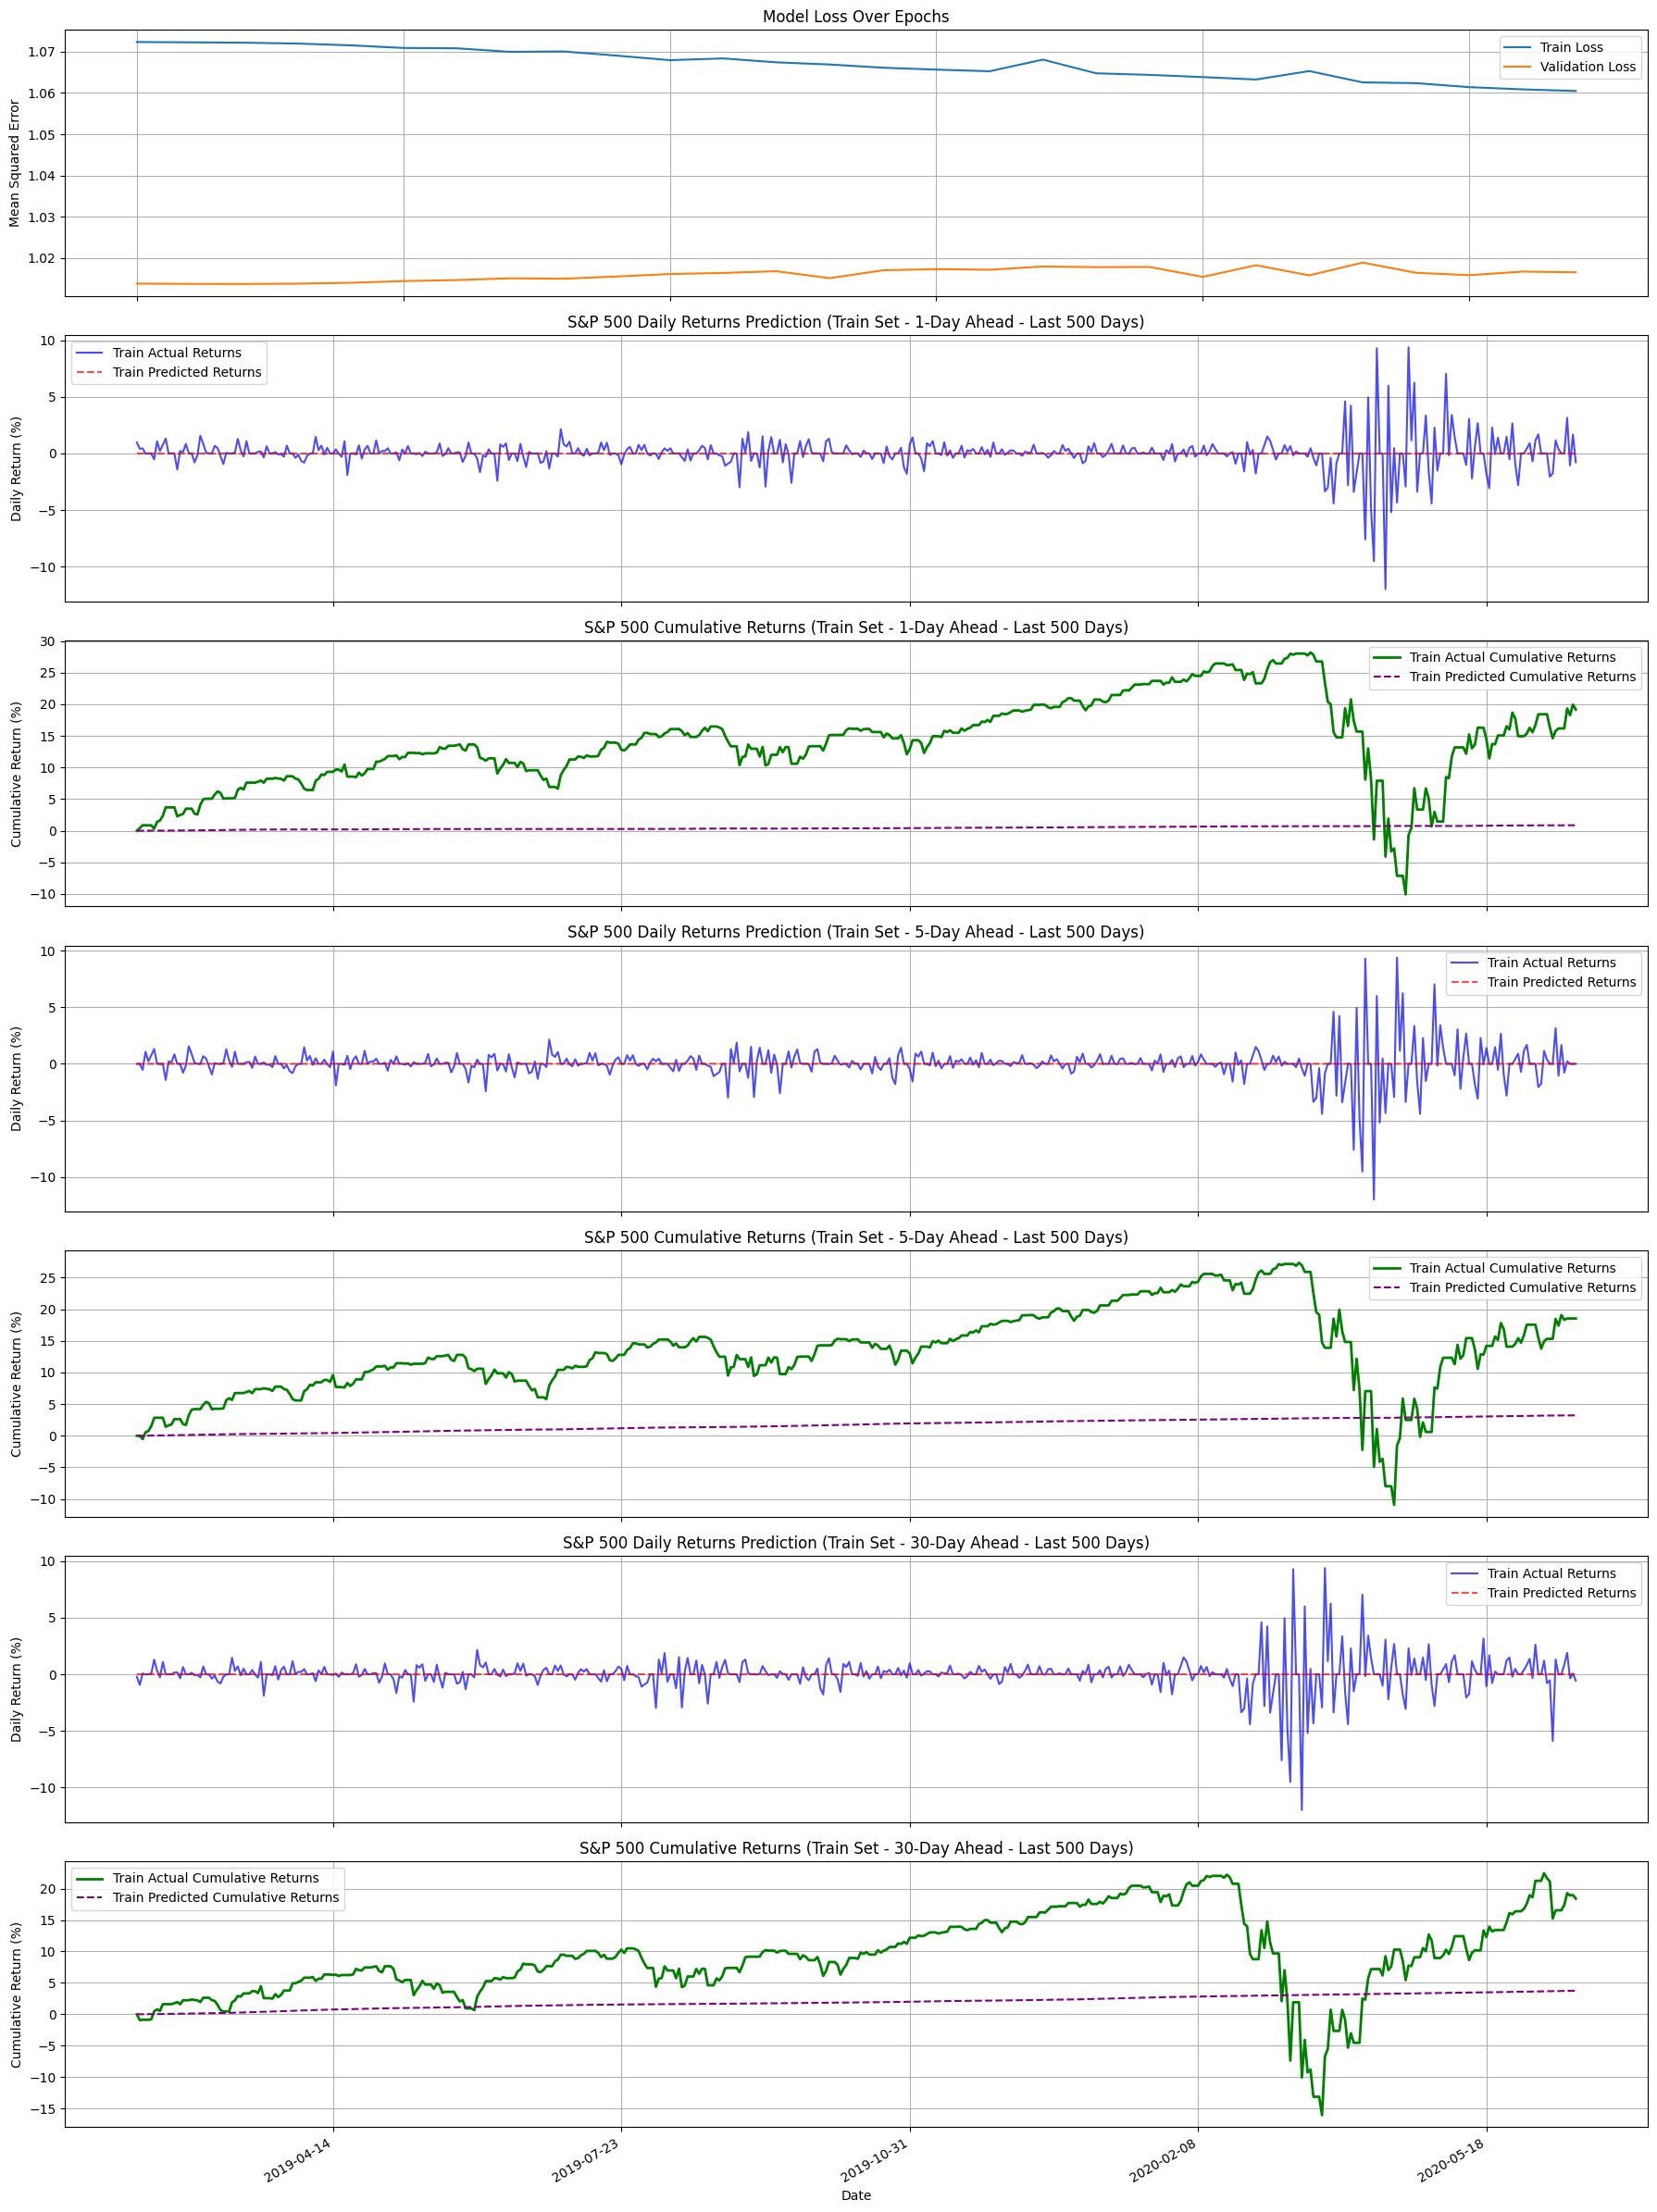

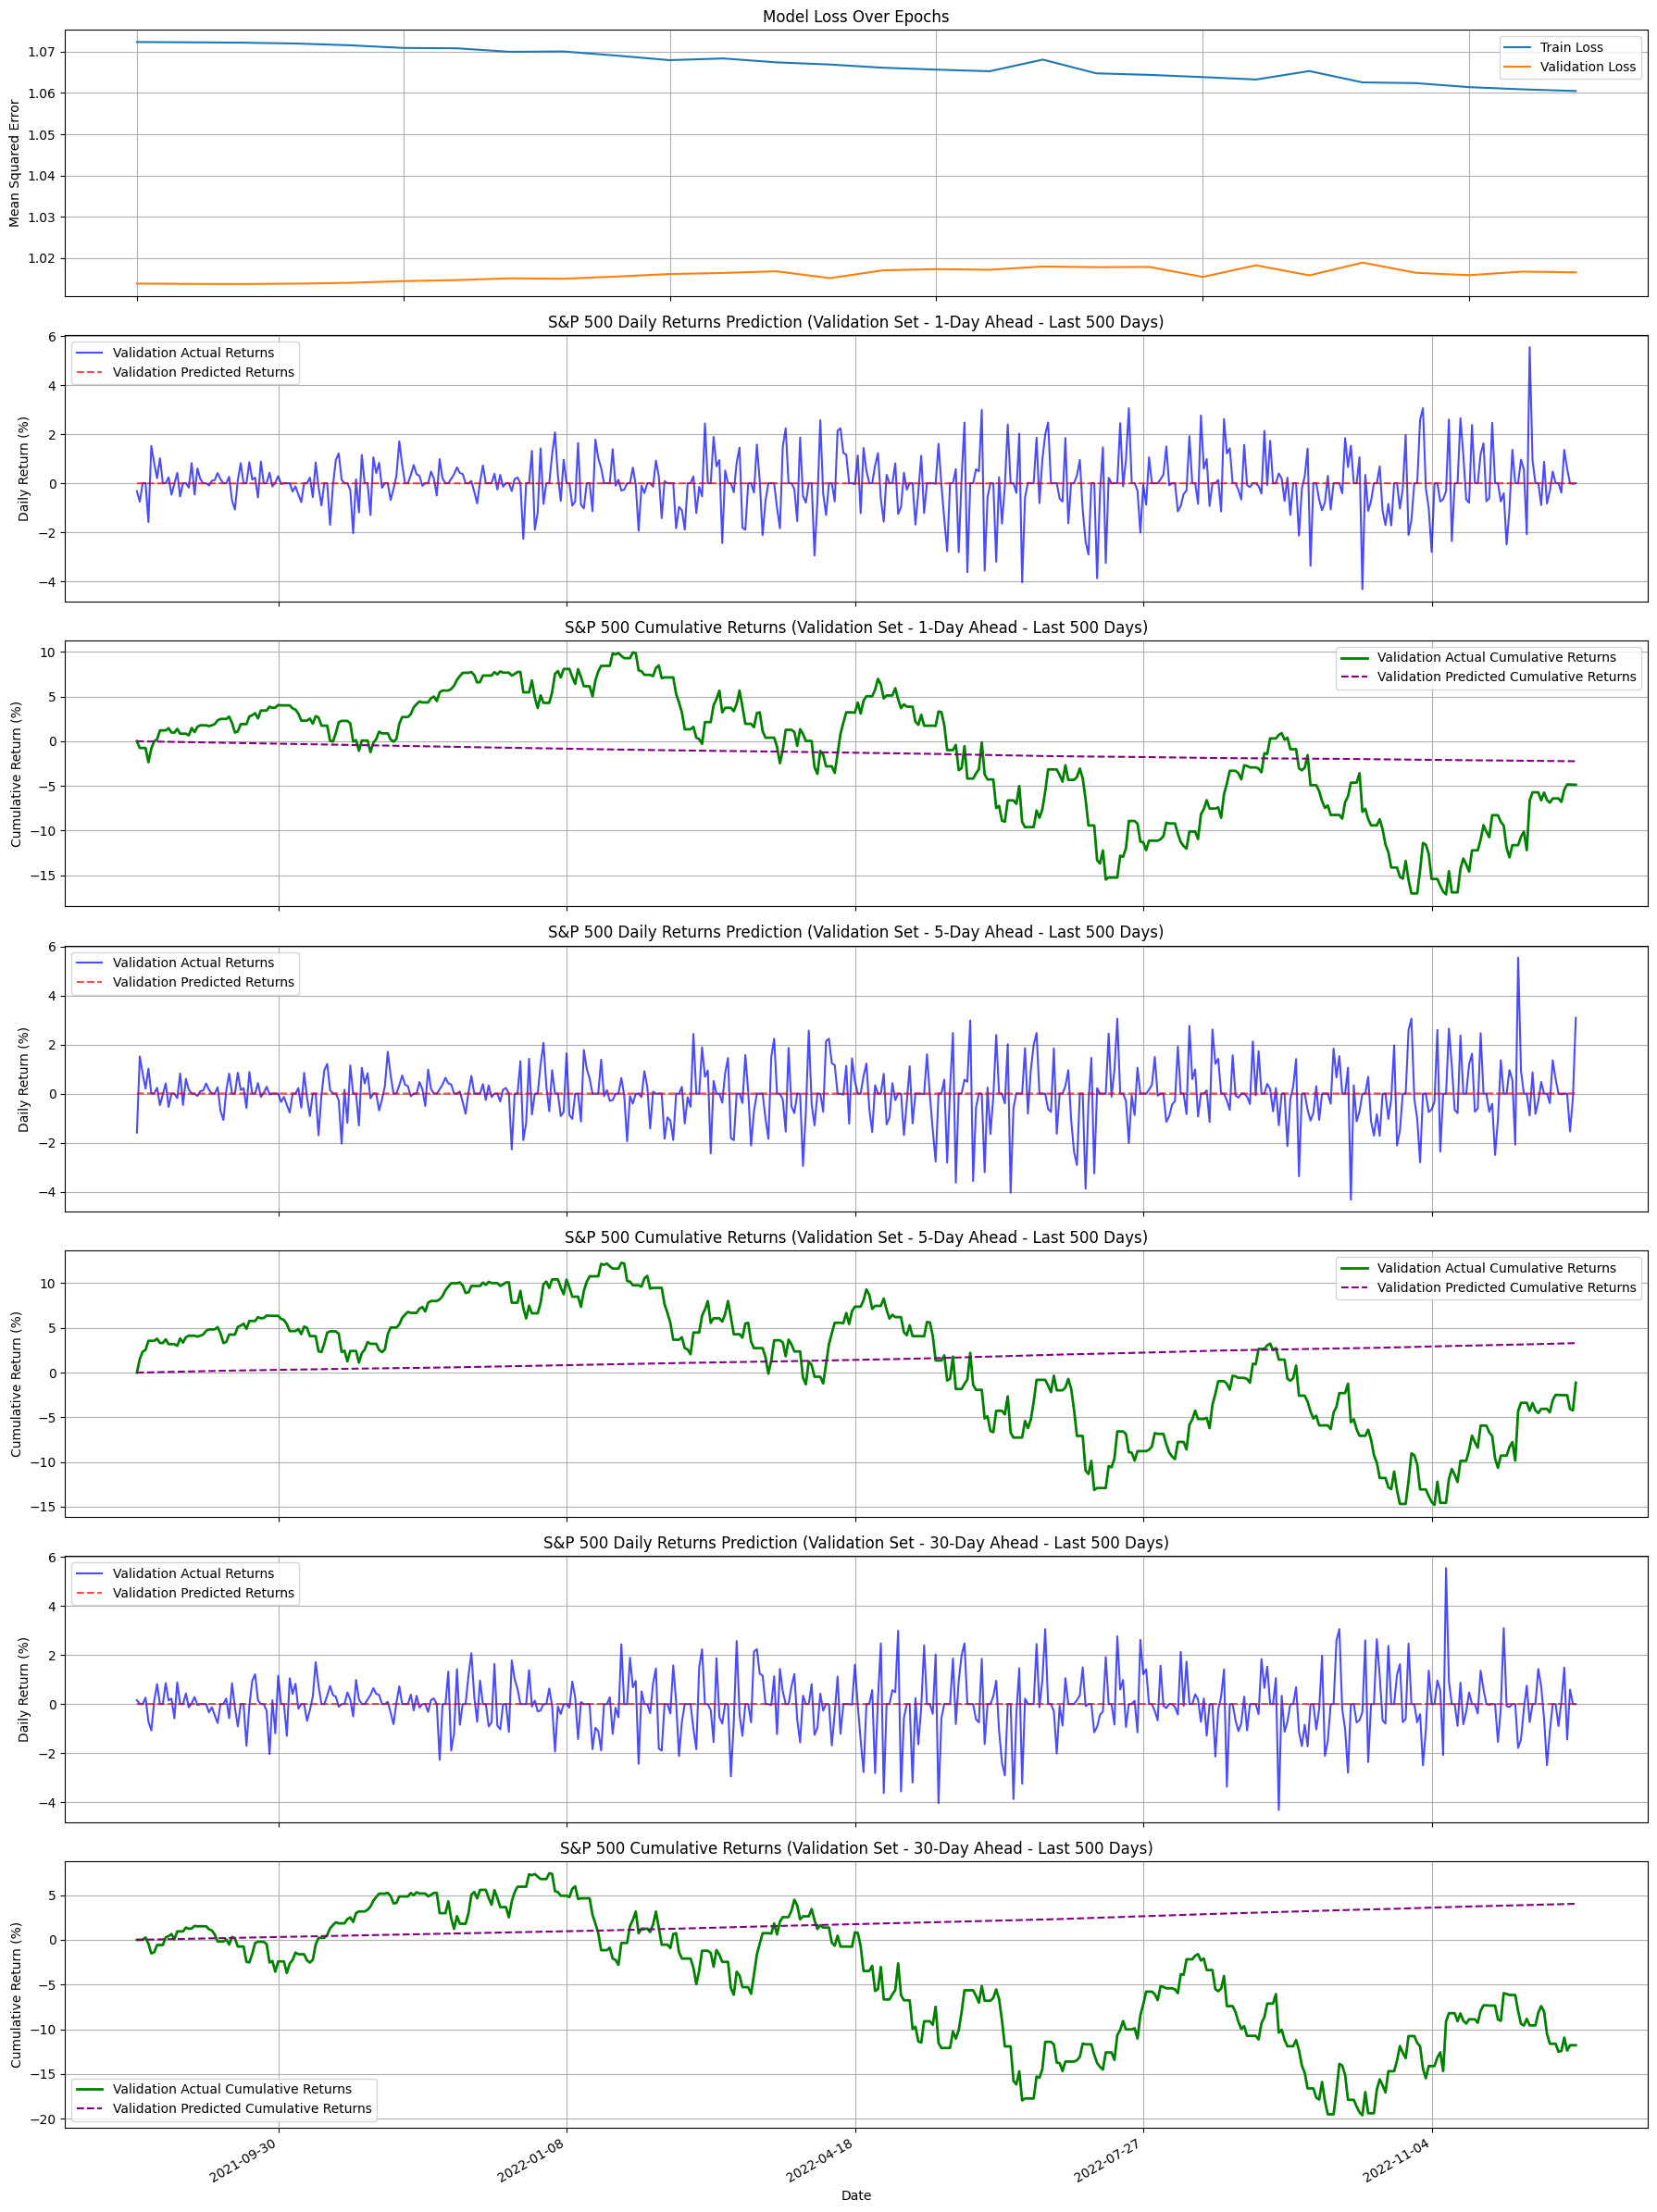

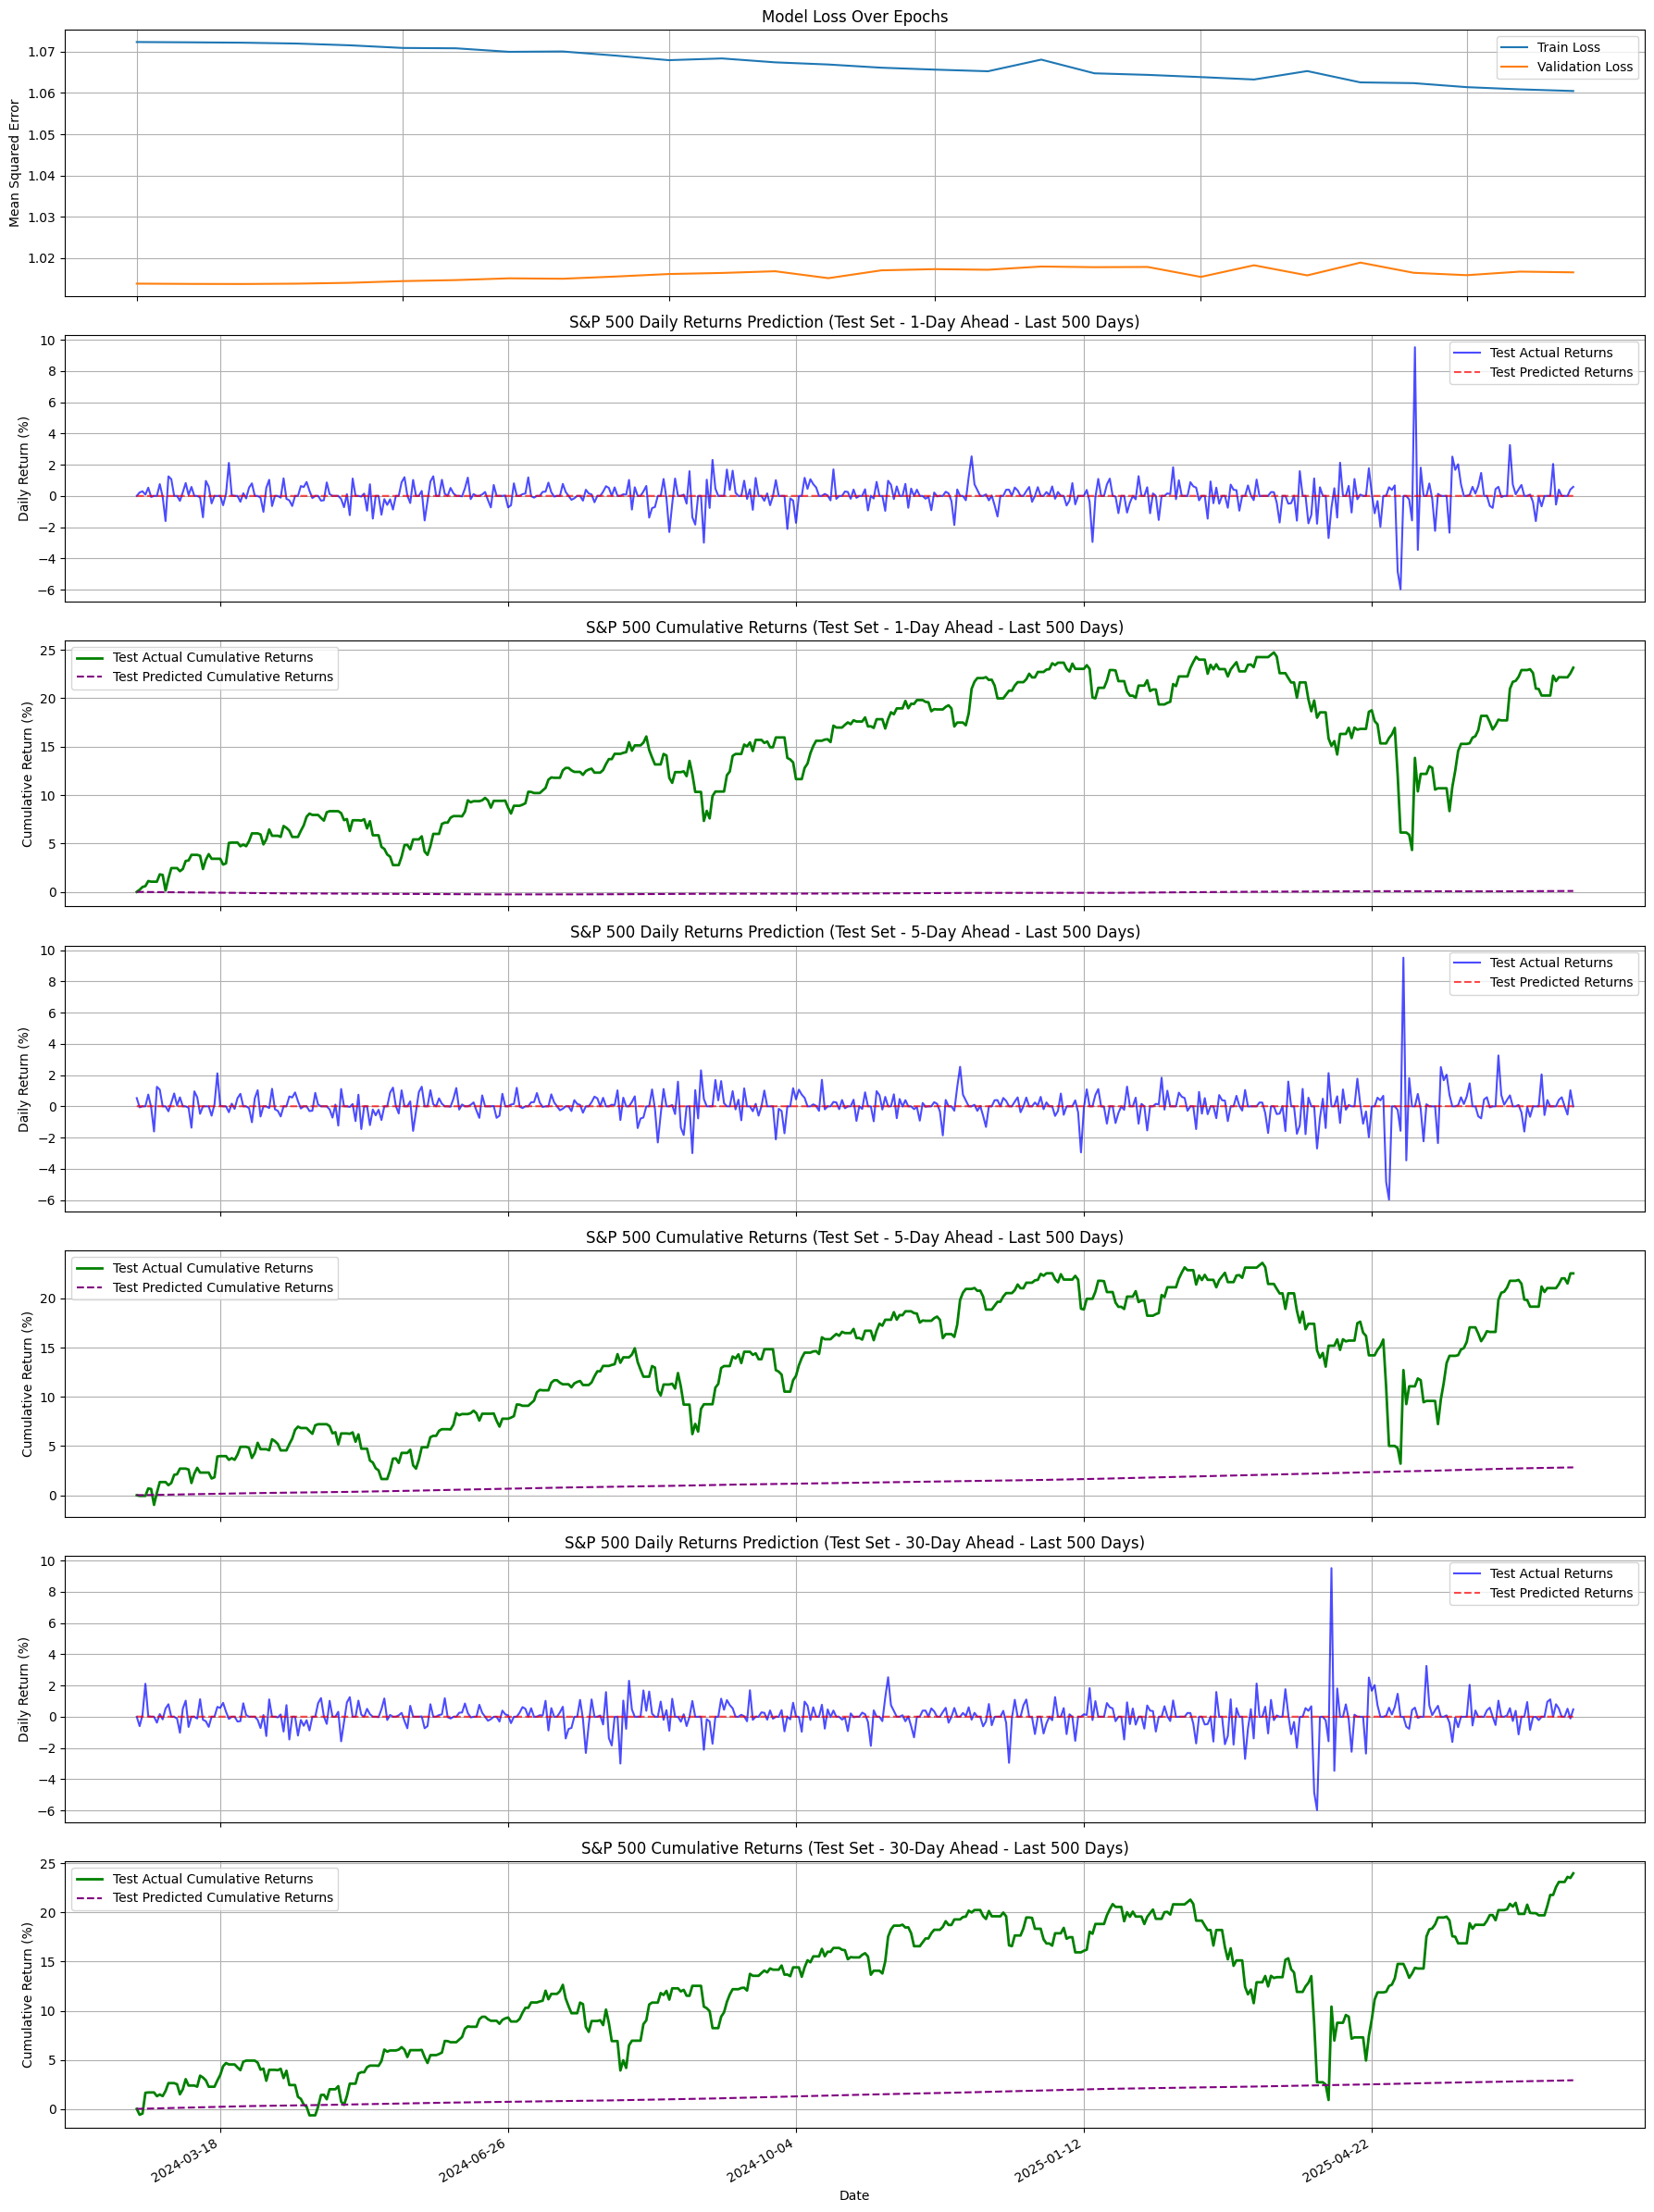

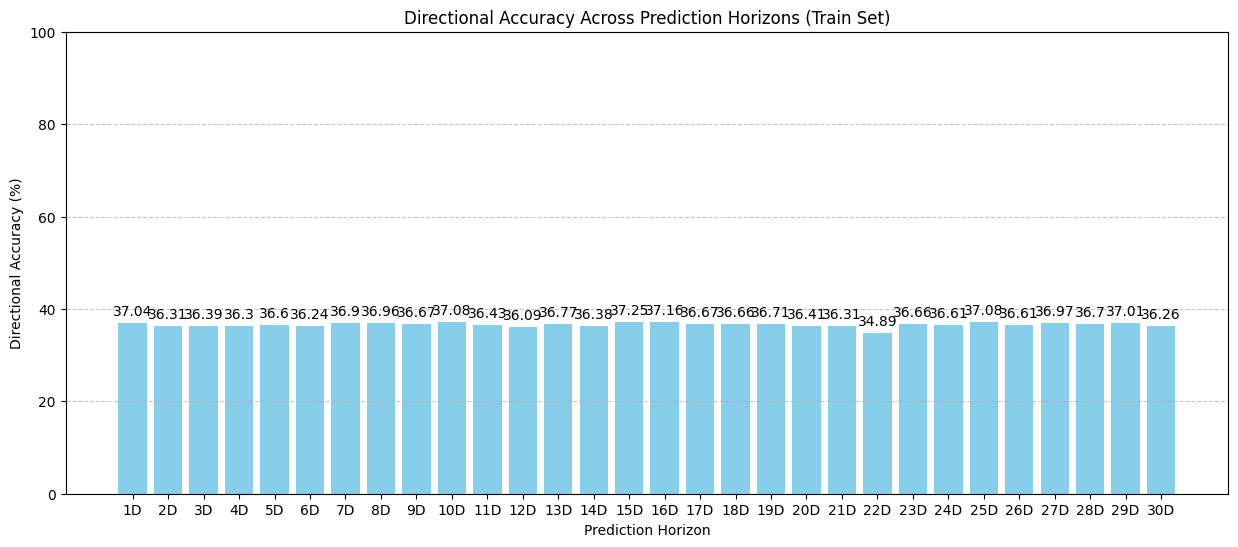

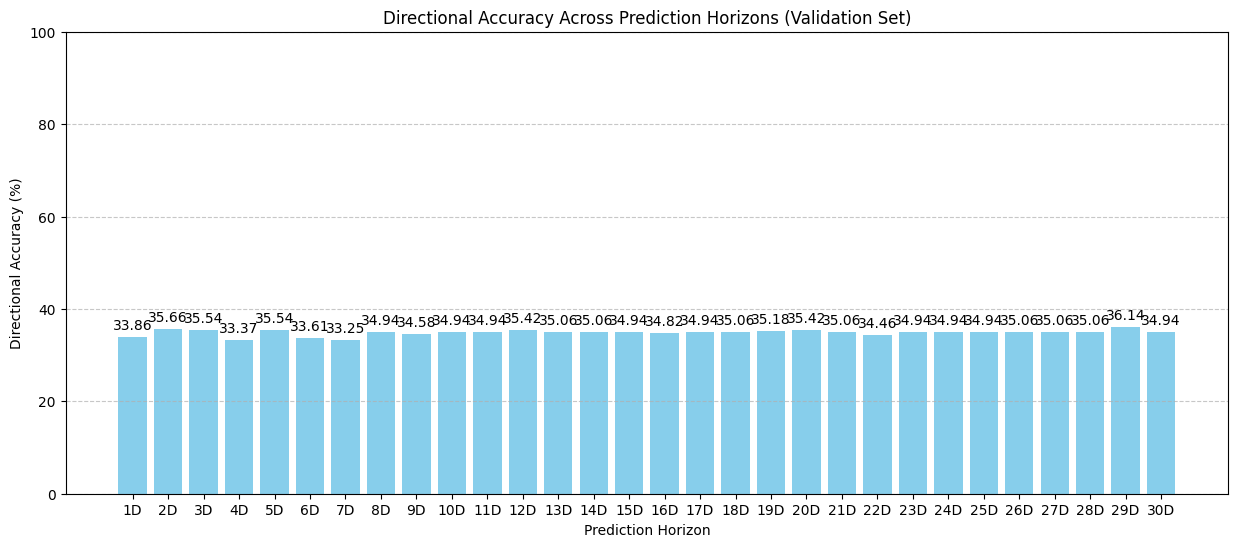

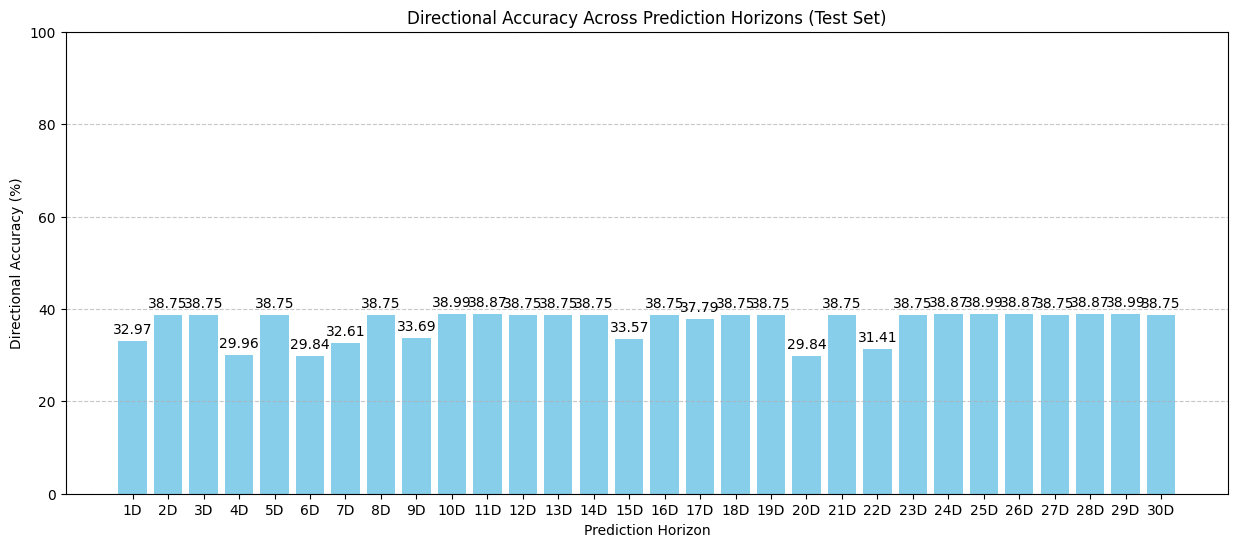

In [ ]:
# 結果の可視化
def plot_results_multi_horizon(history, y_true_seq, y_pred_seq, dates, set_name, pred_horizon_to_plot=None):
    """
    訓練履歴と予測結果をプロットする関数（多出力対応版）
    Args:
        pred_horizon_to_plot (int or list of int, optional): プロットしたい予測ホライズン。
                                                             Noneの場合、1日後の予測のみプロット。
    """
    if pred_horizon_to_plot is None:
        plot_horizons = [0] # 0-indexed で 1日後の予測
    elif isinstance(pred_horizon_to_plot, int):
        plot_horizons = [pred_horizon_to_plot - 1] # ユーザー入力は1-indexed
    else:
        plot_horizons = [h - 1 for h in pred_horizon_to_plot] # リストの場合も1-indexedを0-indexedに変換

    num_plots_per_horizon = 2 # 予測vs実測、累積リターン
    total_subplots = len(plot_horizons) * num_plots_per_horizon + 1 # 損失 + 各ホライズンの2つのプロット

    fig = plt.figure(figsize=(18, 6 * len(plot_horizons) + 6)) # 全体の図のサイズを調整

    # 1. 訓練履歴 (損失)
    plt.subplot(total_subplots, 1, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)

    current_subplot_idx = 2
    for p_idx in plot_horizons:
        # y_true_seq, y_pred_seq は (N, MAX_PRED_HORIZON) 形状
        # p_idx は 0-indexed
        y_true_single_horizon = y_true_seq[:, p_idx]
        y_pred_single_horizon = y_pred_seq[:, p_idx]

        horizon_label = f"{p_idx + 1}-Day Ahead" # プロット用ラベル (1-indexed)

        # 2. 予測 vs 実測値 (特定期間)
        plt.subplot(total_subplots, 1, current_subplot_idx)
        display_start_idx = max(0, len(y_true_single_horizon) - 500)
        display_dates = dates[display_start_idx:]
        display_y_true = y_true_single_horizon[display_start_idx:]
        display_y_pred = y_pred_single_horizon[display_start_idx:]

        plt.plot(display_dates, display_y_true, label=f'{set_name} Actual Returns', color='blue', alpha=0.7)
        plt.plot(display_dates, display_y_pred, label=f'{set_name} Predicted Returns', color='red', linestyle='--', alpha=0.7)
        plt.title(f'S&P 500 Daily Returns Prediction ({set_name} Set - {horizon_label} - Last 500 Days)')
        plt.xlabel('Date')
        plt.ylabel('Daily Return (%)')
        plt.legend()
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mticker.AutoLocator())
        plt.gcf().autofmt_xdate()
        current_subplot_idx += 1

        # 3. 累積リターン (特定期間)
        plt.subplot(total_subplots, 1, current_subplot_idx)
        cumulative_true = np.cumsum(display_y_true)
        cumulative_pred = np.cumsum(display_y_pred)

        # 開始点を0に正規化
        cumulative_true_normalized = cumulative_true - cumulative_true[0]
        cumulative_pred_normalized = cumulative_pred - cumulative_pred[0]

        plt.plot(display_dates, cumulative_true_normalized, label=f'{set_name} Actual Cumulative Returns', color='green', linewidth=2)
        plt.plot(display_dates, cumulative_pred_normalized, label=f'{set_name} Predicted Cumulative Returns', color='purple', linestyle='--', linewidth=1.5)
        plt.title(f'S&P 500 Cumulative Returns ({set_name} Set - {horizon_label} - Last 500 Days)')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return (%)')
        plt.legend()
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mticker.AutoLocator())
        plt.gcf().autofmt_xdate()
        current_subplot_idx += 1

    plt.tight_layout()
    plt.show()

def plot_direction_accuracy_multi_horizon(y_true_seq, y_pred_seq, set_name):
    """
    方向精度を計算し、各予測ホライズンごとにプロットする関数（多出力対応版）
    """
    num_horizons = y_true_seq.shape[1] # 予測ホライズンの数
    accuracies = []

    for i in range(num_horizons):
        y_true_single = y_true_seq[:, i]
        y_pred_single = y_pred_seq[:, i]

        true_direction = np.sign(y_true_single)
        pred_direction = np.sign(y_pred_single)
        correct_directions = np.sum(true_direction == pred_direction)
        total_predictions = len(y_true_single)
        accuracy = correct_directions / total_predictions * 100
        accuracies.append(accuracy)

    horizon_labels = [f'{i+1}D' for i in range(num_horizons)]

    plt.figure(figsize=(15, 6))
    bars = plt.bar(horizon_labels, accuracies, color='skyblue')
    plt.ylabel('Directional Accuracy (%)')
    plt.xlabel('Prediction Horizon')
    plt.title(f'Directional Accuracy Across Prediction Horizons ({set_name} Set)')
    plt.ylim(0, 100) # 0%から100%の範囲
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom') # accuracy値を表示
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# 訓練・検証・テストセットの結果をプロット
# 各ホライズン（1日後、5日後、30日後）の予測を個別にプロット
plot_results_multi_horizon(history, y_train_seq, train_preds, dates_train, 'Train', pred_horizon_to_plot=[1, 5, 30])
plot_results_multi_horizon(history, y_valid_seq, valid_preds, dates_valid, 'Validation', pred_horizon_to_plot=[1, 5, 30])
plot_results_multi_horizon(history, y_test_seq, test_preds, dates_test, 'Test', pred_horizon_to_plot=[1, 5, 30])

# 方向精度を全てのホライズンでプロット
plot_direction_accuracy_multi_horizon(y_train_seq, train_preds, 'Train')
plot_direction_accuracy_multi_horizon(y_valid_seq, valid_preds, 'Validation')
plot_direction_accuracy_multi_horizon(y_test_seq, test_preds, 'Test')